In [1]:
import duckdb
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

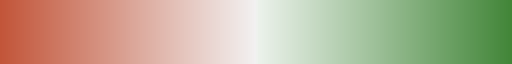

In [3]:
sns.set_theme()
sns.set_style('ticks', {"axes.grid": True})
sns.set_context('talk')
hm_w = 7.5
hm_h = 2.75
set_title = False
my_cmap = sns.diverging_palette(20, 125, as_cmap=True)
my_cmap

In [4]:
my_palette = sns.diverging_palette(20, 125)
my_palette

[(0.7634747047461135, 0.3348456555528834, 0.225892295531744),
 (0.8384144678873866, 0.5785740917778832, 0.5129511551488872),
 (0.9140860646530862, 0.8246826885128927, 0.8028133239419791),
 (0.7974936879014439, 0.868249489534432, 0.788438813627399),
 (0.5270994310316574, 0.6954476571009066, 0.5033714796732588),
 (0.25932020565964425, 0.5243170222731213, 0.22106108318482592)]

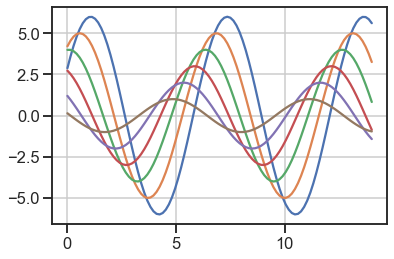

In [5]:
x = np.linspace(0, 14, 100)
for i in range(1, 7):
    plt.plot(x, np.sin(x + i * .5) * (7 - i) * 1)

In [6]:
con = duckdb.connect()
grouping_cols = ['count', 'columns', 'col_width', 'category']

# Functions

In [7]:
def load_csv(con, csv_path, median_cols):
    q = "select "
    q += ", ".join(grouping_cols)
    q += ", " + ", ".join([f"median({c}) as {c}" for c in median_cols])
    q += f" from read_csv_auto('{csv_path}') "
    q += "group by " + ", ".join(grouping_cols)
    q += " order by " + ", ".join(grouping_cols)
    con.execute(q)
    return con.fetchdf()

In [8]:
def compute_relative_runtime(con, df, cat1, cat2, col):
    q = "select\n\tcast(log2(c1.count) as int) as row_count,"
    q += f"\n\tc1.columns,\n\tc1.col_width,\n\tc1.{col} as {cat1}_{col},\n\tc2.{col} as {cat2}_{col},"
    q += f"\n\tround(c1.{col} / c2.{col}, 1) as relative_runtime"
    q += f"\nfrom\n\tdf c1,\n\tdf c2"
    q += f"\nwhere\n\tc1.category = '{cat1}'\nand\tc2.category = '{cat2}'\nand\t"
    q += "\nand\t".join([f"c1.{c} = c2.{c}" for c in grouping_cols[:-1]])
    q += "\norder by\n\trow_count,\n\t"
    q += ",\n\t".join([f"c1.{c}" for c in grouping_cols[1:-1]])
    con.execute(q)
    return con.fetchdf()

In [9]:
def create_heatmap(df, columns, title, fname, w=hm_w, h=hm_h):
    fig, ax = plt.subplots(figsize=(w, h))
    g = sns.heatmap(df.pivot(columns[0], columns[1], columns[2]), linewidths=0, center=1, cmap=my_cmap, ax=ax,
                    annot=True, annot_kws={'c': 'black'}, robust=True, cbar=False)
    g.invert_yaxis()
    for _, spine in ax.spines.items():
        spine.set_visible(True)
    labels = ['$2^{' + item.get_text() + '}$' for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels)
    if set_title:
        plt.title(f'Relative runtime of {title}')
    ax.set_xlabel('rows')
    plt.savefig(f'figures/{fname}.eps', bbox_inches="tight")
    plt.show()

In [10]:
def multi_heatmap(dfs, titles, columns, fname, w=hm_w, h=hm_h):
    fig, axes = plt.subplots(nrows=1, ncols=len(dfs), figsize=(w *len(dfs), h), sharey=True)
    for i in range(len(dfs)):
        ax = axes[i]
        sns.heatmap(dfs[i].pivot(columns[0], columns[1], columns[2]), linewidths=0, center=1, cmap=my_cmap, ax=ax,
                    annot=True, annot_kws={'c': 'black'}, robust=True, cbar=False)
        ax.invert_yaxis()
        for _, spine in ax.spines.items():
            spine.set_visible(True)
        labels = ['$2^{' + item.get_text() + '}$' for item in ax.get_xticklabels()]
        ax.set_xticklabels(labels)
        ax.set_xlabel('rows')
        ax.set_title(titles[i])
        if i > 0:
            ax.set_ylabel('')
            plt.setp(ax.get_yticklabels(), visible=False)
            ax.tick_params(axis='y', which='major', length=0)
    plt.subplots_adjust(wspace=0.05)
    plt.savefig(f'figures/{fname}.eps', bbox_inches="tight")
    plt.show()

# Reordering

In [11]:
reorder_df = load_csv(con, 'results/reorder.csv', ['total', 'reorder', 'scatter', 'gather'])
con.execute("select category, sum(total) from reorder_df group by category")
con.fetchdf()

,category,sum(total)
0,col,1.136658e+10
1,row,1.243154e+10


In [12]:
reorder_total_df = compute_relative_runtime(con, reorder_df, 'col', 'row', 'total')
con.execute("select avg(relative_runtime), median(relative_runtime) from reorder_total_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,0.496429,0.4


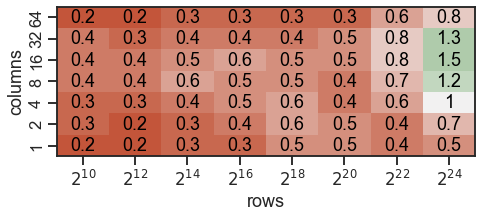

In [13]:
create_heatmap(reorder_total_df,
               ['columns', 'row_count', 'relative_runtime'],
               'payload reordering rows vs. columns (incl. scatter + gather)',
               'reorder_incl_sg')

In [14]:
reorder_only_df = compute_relative_runtime(con, reorder_df, 'col', 'row', 'reorder')
con.execute("select avg(relative_runtime), median(relative_runtime) from reorder_only_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,1.6,1.4


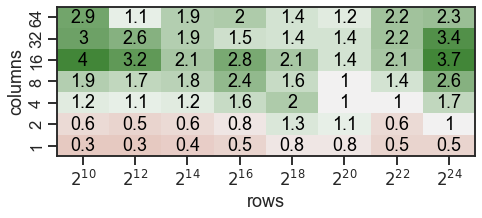

In [15]:
create_heatmap(reorder_only_df,
               ['columns', 'row_count', 'relative_runtime'],
               'payload reordering rows vs. columns (excl. scatter + gather)',
               'reorder_excl_sg')

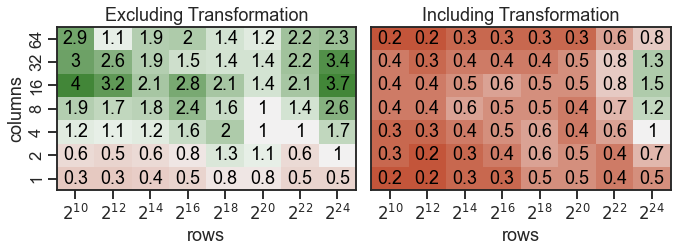

In [16]:
multi_heatmap([reorder_only_df, reorder_total_df], ['Excluding Transformation', 'Including Transformation'],
              ['columns', 'row_count', 'relative_runtime'],
              'reorder', w=5.5, h=3)

In [17]:
con.execute("""
    select
        cast(log2(count) as int) as row_count,
        columns,
        col_width,
        reorder as "row reorder",
        round(cast(scatter + gather as double) / total, 1) as sg
    from
        reorder_df
    where
        category = 'row'
    order by
        row_count asc,
        columns asc
""")
reorder_percentage_df = con.fetchdf()
con.execute('select avg(sg), median(sg) from reorder_percentage_df')
con.fetchdf()

,avg(sg),median(sg)
0,0.616071,0.65


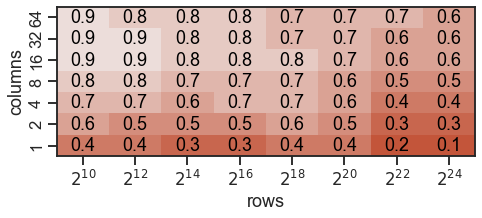

In [18]:
create_heatmap(reorder_percentage_df,
               ['columns', 'row_count', 'sg'],
               'scatter + gather as percentage of reorder runtime',
               'reorder_sg_percentage')

# Comparator

In [19]:
comparator_df = load_csv(con, 'results/comparator.csv', ['total', 'sort', 'scatter', 'gather'])
con.execute("select category, sum(total) from comparator_df group by category")
con.fetchdf()

,category,sum(total)
0,col,586246166.0
1,col_branchless,899911754.0
2,col_ss,263136044.0
3,row_all,336936166.0
4,row_all_branchless,465570292.0
5,row_iter,234691838.0
6,row_norm,301614379.0


In [20]:
con.execute("""
select 
       min(1 - sort / total) as min_sg,
       max(1 - sort / total) as max_sg,
       avg(1 - sort / total) as avg_sg,
       median(1 - sort / total) as median_sg
from comparator_df
where category != 'col'
  and category != 'col_branchless'
  and category != 'col_ss'
-- order by category
""")
con.fetchdf()
# print(con.fetchdf().to_latex(index=False, float_format='%.2f'))

,min_sg,max_sg,avg_sg,median_sg
0,0.031012,0.191595,0.076587,0.071172


In [21]:
comparator_col_iter_df = compute_relative_runtime(con, comparator_df, 'col', 'col_ss', 'sort')
con.execute("select avg(relative_runtime), median(relative_runtime) from comparator_col_iter_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,1.655556,1.6


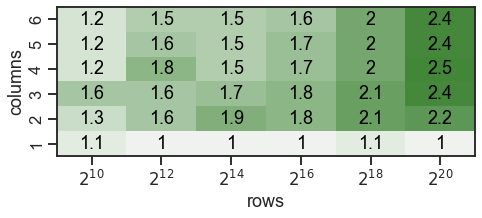

In [22]:
create_heatmap(comparator_col_iter_df,
               ['columns', 'row_count', 'relative_runtime'],
               'columnar_iterative vs. columnar_all (pdqsort)',
               'comparator_col_iter')

In [23]:
comparator_col_branchless_df = compute_relative_runtime(con, comparator_df, 'col', 'col_branchless', 'sort')
con.execute("select avg(relative_runtime), median(relative_runtime) from comparator_col_branchless_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,0.775,0.8


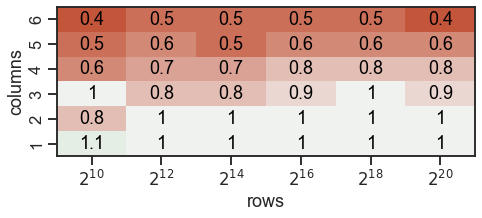

In [24]:
create_heatmap(comparator_col_branchless_df,
               ['columns', 'row_count', 'relative_runtime'],
               'columnar_branchless vs. columnar_all (pdqsort)',
               'comparator_col_branchless')

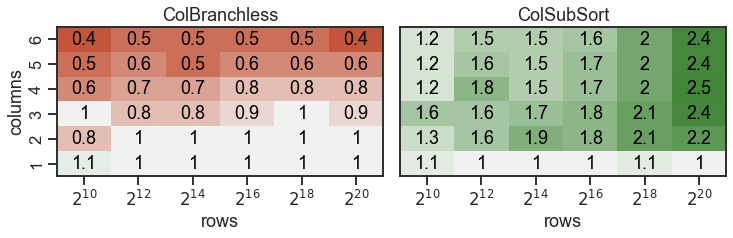

In [25]:
multi_heatmap([comparator_col_branchless_df, comparator_col_iter_df],
              ['ColBranchless', 'ColSubSort'],
              ['columns', 'row_count', 'relative_runtime'],
              'column_comparators', w=6, h=2.75)

In [26]:
comparator_row_all_df = compute_relative_runtime(con, comparator_df, 'col_ss', 'row_all', 'sort')
con.execute("select avg(relative_runtime), median(relative_runtime) from comparator_row_all_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,0.980556,0.9


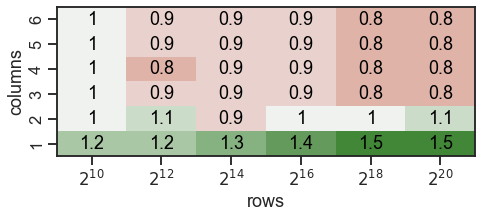

In [27]:
create_heatmap(comparator_row_all_df,
               ['columns', 'row_count', 'relative_runtime'],
               'row_all vs. columnar_iterative (pdqsort)',
               'comparator_row_all')

In [28]:
comparator_row_iter_df = compute_relative_runtime(con, comparator_df, 'col_ss', 'row_iter', 'sort')
con.execute("select avg(relative_runtime), median(relative_runtime) from comparator_row_iter_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,1.186111,1.2


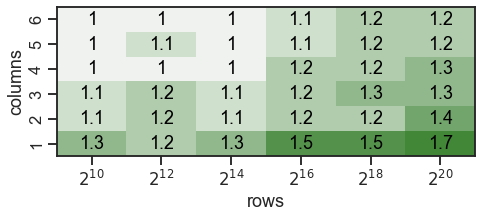

In [29]:
create_heatmap(comparator_row_iter_df,
               ['columns', 'row_count', 'relative_runtime'],
               'row_iter vs. columnar_iterative (pdqsort)',
               'comparator_row_iter')

In [30]:
comparator_row_branchless_df = compute_relative_runtime(con, comparator_df, 'col_ss', 'row_all_branchless', 'sort')
con.execute("select avg(relative_runtime), median(relative_runtime) from comparator_row_branchless_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,0.805556,0.7


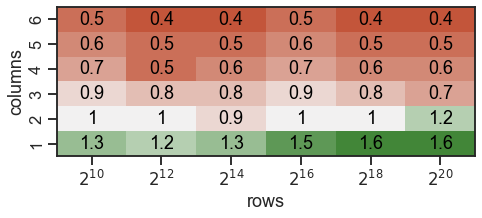

In [31]:
create_heatmap(comparator_row_branchless_df,
               ['columns', 'row_count', 'relative_runtime'],
               'row_all_branchless vs. row_all (pdqsort)',
               'comparator_row_branchless')

In [32]:
comparator_norm_key_df = compute_relative_runtime(con, comparator_df, 'col_ss', 'row_norm', 'sort')
con.execute("select avg(relative_runtime), median(relative_runtime) from comparator_norm_key_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,1.047222,1.1


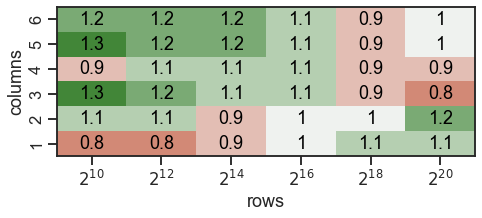

In [33]:
create_heatmap(comparator_norm_key_df,
               ['columns', 'row_count', 'relative_runtime'],
               'normalized_key vs. columnar_iterative (pdqsort)',
               'comparator_norm_key')

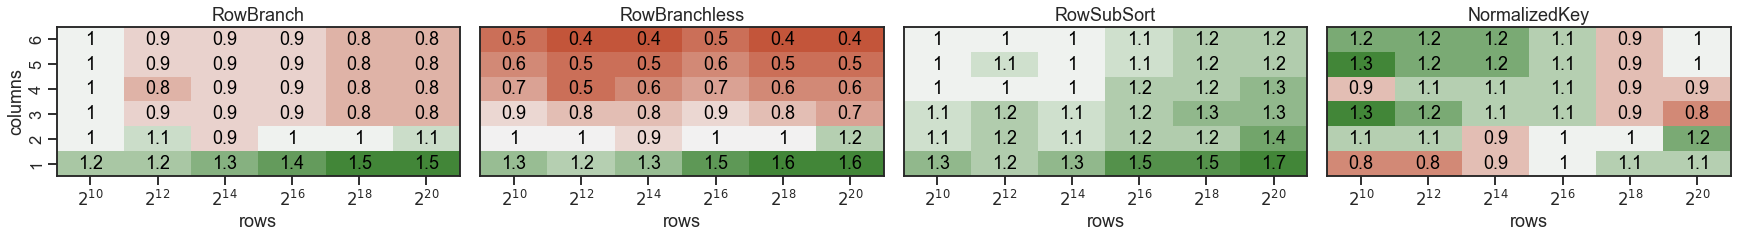

In [34]:
multi_heatmap([comparator_row_all_df, comparator_row_branchless_df, comparator_row_iter_df, comparator_norm_key_df],
              ['RowBranch', 'RowBranchless', 'RowSubSort', 'NormalizedKey'],
              ['columns', 'row_count', 'relative_runtime'],
              'row_comparators', w=7.5, h=2.75)

# Sort

In [36]:
sort_skewed_df = load_csv(con, 'results/sort_skewed.csv', ['total', 'sort', 'scatter', 'gather'])
con.execute("select category, sum(sort) from sort_skewed_df group by category")
con.fetchdf()

,category,sum(sort)
0,pdq_static,4.960623e+09
1,radix,4.378993e+09


In [37]:
sort_skewed_rel_df = compute_relative_runtime(con, sort_skewed_df, 'pdq_static', 'radix', 'sort')
con.execute("select avg(relative_runtime), median(relative_runtime) from sort_skewed_rel_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,0.922917,0.9


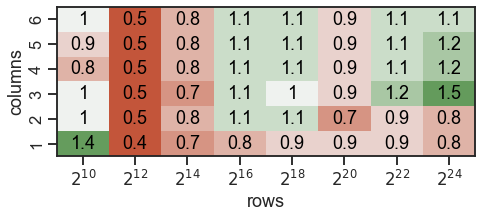

In [38]:
create_heatmap(sort_skewed_rel_df,
               ['columns', 'row_count', 'relative_runtime'],
               'pdq_static vs. radix',
               'sort_skewed')

In [39]:
sort_random_df = load_csv(con, 'results/sort_random.csv', ['total', 'sort', 'scatter', 'gather'])
con.execute("select category, sum(sort) from sort_random_df group by category")
con.fetchdf()

,category,sum(sort)
0,pdq_static,4.572771e+09
1,radix,3.396126e+09


In [40]:
sort_random_rel_df = compute_relative_runtime(con, sort_random_df, 'pdq_static', 'radix', 'sort')
con.execute("select avg(relative_runtime), median(relative_runtime) from sort_random_rel_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,1.447917,1.2


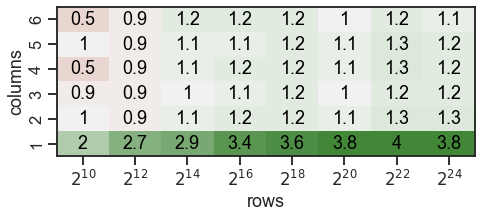

In [41]:
create_heatmap(sort_random_rel_df,
               ['columns', 'row_count', 'relative_runtime'],
               'pdq_static vs. radix',
               'sort_random')

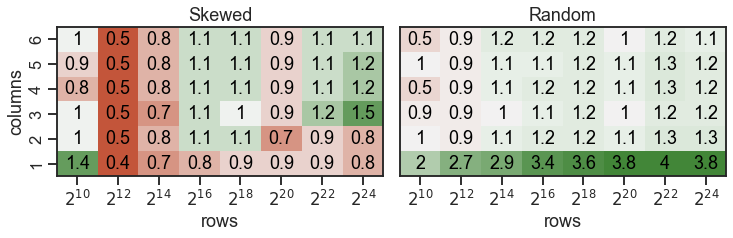

In [42]:
multi_heatmap([sort_skewed_rel_df, sort_random_rel_df],
              ['Skewed', 'Random'],
              ['columns', 'row_count', 'relative_runtime'],
              'sort', w=6, h=2.75)

# Merge Key

In [43]:
merge_key_df = load_csv(con, 'results/merge_key.csv', ['total'])
con.execute("select category, sum(total) from merge_key_df group by category")
con.fetchdf()

,category,sum(total)
0,col_branch,84937039.0
1,col_branchless,186581664.0
2,row_all,20121375.0
3,row_all_branchless,67183585.0
4,row_norm,39888039.0


In [60]:
merge_key_runtime = compute_relative_runtime(con, merge_key_df, 'row_all_branchless', 'row_norm', 'total')
con.execute("select avg(relative_runtime), median(relative_runtime) from merge_key_runtime")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,2.15,2.3


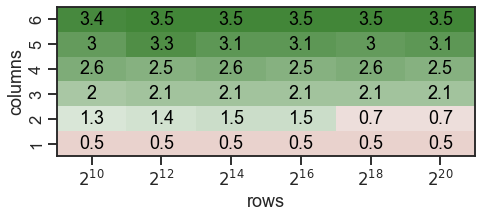

In [61]:
create_heatmap(merge_key_runtime,
               ['columns', 'row_count', 'relative_runtime'],
               'merge normalized key vs. merge key columnar',
               'merge_key')

# Merge Payload

In [46]:
merge_payload_df = load_csv(con, 'results/merge_payload.csv', ['total'])
con.execute("select category, sum(total) from merge_payload_df group by category")
con.fetchdf()

,category,sum(total)
0,col,436260252.0
1,row,288919462.0


In [47]:
merge_payload_runtime_df = compute_relative_runtime(con, merge_payload_df, 'col', 'row', 'total')
con.execute("select avg(relative_runtime), median(relative_runtime) from merge_payload_runtime_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,1.519048,1.4


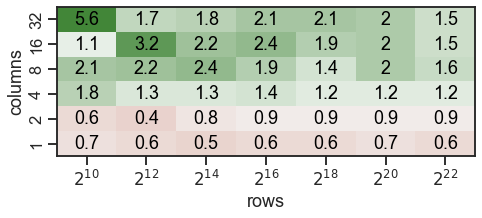

In [48]:
create_heatmap(merge_payload_runtime_df,
               ['columns', 'row_count', 'relative_runtime'],
               'merging rows vs. merging columns',
               'merge_payload')

# Static vs. Dynamic

In [49]:
mem_colors = [my_palette[0], my_palette[5]]

In [50]:
con.execute("""
select 'memcpy' as function, * from read_csv_auto('results/memcpy.csv')
union all
select 'memcmp' as function, * from read_csv_auto('results/memcmp.csv')
""")
mem_df = con.fetchdf()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


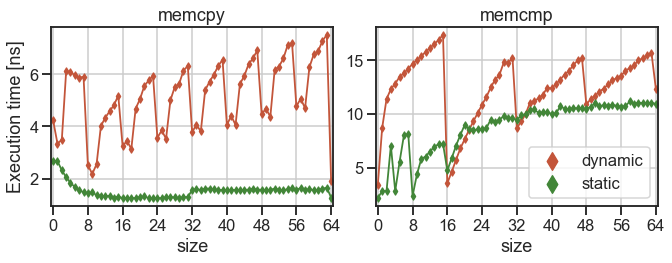

In [51]:
with plt.rc_context({'lines.linewidth': 1}):
    plot = sns.catplot(data=mem_df, kind='point', x='num_bytes', y='time', col='function', hue='type', col_wrap=2,
                       sharex=True, sharey=False, markers=['d', 'd'], height=4, palette=mem_colors,
                       facet_kws=dict(despine=False))

plot.axes[0].set(ylabel='Execution time [ns]', xlabel='size', title='memcpy')
plot.axes[1].set(ylabel=None, xlabel='size', title='memcmp')

for ax in plot.axes:
    ax.xaxis.set_major_locator(ticker.MultipleLocator(8))
    ax.grid(True)
    for col in ax.collections:
        col.set_sizes([25])

plot._legend.set_visible(False)
with plt.rc_context({'legend.markerscale': 2.5}):
    lgnd = plot.axes[1].legend()

plt.tight_layout()
plt.subplots_adjust(wspace=0.15)
plt.savefig('figures/mem.eps', bbox_inches='tight')

In [ ]:
con.execute("""
select max(d.time / s.time) as speedup, d.function, d.num_bytes
from mem_df d, mem_df s
where d.type = 'dynamic'
and s.type = 'static'
and d.function = s.function
and d.num_bytes = s.num_bytes
group by d.function, d.num_bytes
order by speedup desc
""")
speedup = con.fetchdf()
speedup.head(20)

# Trace

In [ ]:
def process_trace_csv(con, csv_path, counter, ns_per_grp):
    time_group_size = 20000000
    if counter is 'cm':
        counter = 'L1D_CACHE_MISS_LD + L1D_CACHE_MISS_ST'
    elif counter is 'bm':
        counter = 'BRANCH_COND_MISPRED_NONSPEC'
    else:
        '4' + 2
    con.execute(f"""
    with trace_csv1 as (select * from read_csv_auto('{csv_path}', sample_size=30000)),
    trace_csv2 as (
        select
            category,
            cast(time / {ns_per_grp} as bigint) as time,
            {counter} as counter
        from trace_csv1
    ),
    trace_csv3 as (
        select category, time, sum(counter) counter
        from trace_csv2
        group by category, time
    ),
    trace_csv4 as (
        select category, time, counter, cast(lag(time, 1) over (partition by category order by time) as int) as l
        from trace_csv3
    ),
    bounds as (
        select * from trace_csv4 where time - 1 != l
    ),
    filtered as (
        select *
        from trace_csv4 t
        where
            time >= (select min(time) from bounds b where t.category = b.category)
        and time < (select max(time) from bounds b where t.category = b.category)
    ),
    trace as (
        select
            category,
            (time - (select min(time) from filtered fs where f.category = fs.category group by category)) * {ns_per_grp} as time,
            counter
        from filtered f
    )
    select category,
    time,
    sum(counter) over (partition by category order by time rows between unbounded preceding and current row) counter
    from trace
    order by category, time
    """)
    result = con.fetchdf()
    print('rows:', len(result))
    con.execute("select max(time) from result")
    print('max time:', con.fetchall()[0][0])
    return result

In [ ]:
my_palette

In [ ]:
my_palette2 = sns.diverging_palette(410, 300)
my_palette2

In [ ]:
trace_palette_map = {
    'Branch': my_palette[0],
    'Branchless': my_palette[5],
    'SubSort': my_palette2[0],
    'NormalizedKey': my_palette2[5]
}

In [ ]:
def plot_trace(df, counter, fig_name, categories=None, h=5, asp=1, the_ax=None, lg=False, yl=True, title=None):
    if not the_ax:
        plt.figure(figsize=(h*asp, h))
    if categories:
        if len(categories) == 2:
            palette = [my_palette[0], my_palette[5]]
            markers = ['d', 'd']
        else:
            markers = ['d' if 'Col' in cat else 's' for cat in categories]
            palette = [trace_palette_map.get(cat.replace('Col', '').replace('Row', ''), my_palette[0]) for cat in categories]
    else:
        markers = ['d']*20
        palette = sns.color_palette()
    with plt.rc_context({'lines.linewidth': 1}):
        ax = sns.pointplot(data=df, x='time', y='counter', hue='category',
                           markers=markers, height=h, aspect=asp, facet_kws=dict(despine=False),
                           palette=palette, ax=the_ax, legend=False)
        ax.legend([], [], frameon=False)
    
    if max(df['counter']) / 1e9 > 1:
        q = '× 1e9'
        y_divisor = 1e9
    elif max(df['counter']) / 1e6 > 1:
        q = '× 1e6'
        y_divisor = 1e6
    elif max(df['counter']) / 1e3 > 1:
        q = '× 1e3'
        y_divisor = 1e3

    if counter == 'cm':
        ylabel = f'Cache misses {q}'
    else:
        ylabel = f'Branch mispredictions {q}'
    
    if yl:
        ax.set(ylabel=ylabel, xlabel='Execution time [s]')
    else:
        ax.set(ylabel='', xlabel='Execution time [s]')
        ax.set_ylabel('')
        plt.setp(ax.get_yticklabels(), visible=False)
        plt.subplots_adjust(wspace=0)

    ax.set_title(title)
    xlabels = [item.get_text() for item in ax.get_xticklabels()]
    ax.set_xticklabels([f'{float(label) / 1e9}' for label in xlabels])
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.tick_params(axis='y', which='major', length=0)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: float(x / y_divisor)))

    ax.grid(True)
    for col in ax.collections:
        col.set_sizes([40])

    if lg:
        with plt.rc_context({'legend.markerscale': 2}):
            lgnd = ax.legend(fontsize='small')
        if categories:
            for new, old in zip(categories, lgnd.get_texts()):
                old.set_text(new)
    
    if not the_ax:
        plt.savefig(f'figures/{fig_name}.eps', bbox_inches='tight')

In [ ]:
def multi_trace(dfs, fig_name, categories, counters, h=5, asp=1, lg=0, titles=[None, None]):
    shy = counters[0] == counters[1]
    plot, axes = plt.subplots(nrows=1, ncols=2, figsize=(2 * h * asp, h), sharey=shy)
    for i in range(2):
        legend_on = lg == i
        if i == 1 and counters[0] == counters[1]:
            yl = False
        else:
            yl = True
        plot_trace(dfs[i], counters[i], '', categories=categories, h=h, asp=asp, the_ax=axes[i],
                   lg=legend_on, yl=yl, title=titles[i])
    plt.tight_layout()
    plt.savefig(f'figures/{fig_name}.eps', bbox_inches='tight')
    plt.show()

## Reorder

In [ ]:
cm_reorder_excl_df = process_trace_csv(con, 'results/trace_reorder_excl.csv', 'cm', 75000000)

In [ ]:
max(cm_reorder_excl_df['counter'])

In [ ]:
plot_trace(cm_reorder_excl_df, 'cm', 'cm_reorder_excl', ['Columns', 'Rows'], h=5, asp=1.5, lg=True)

In [ ]:
cm_reorder_incl_df = process_trace_csv(con, 'results/trace_reorder_incl.csv', 'cm', 100000000)

In [ ]:
plot_trace(cm_reorder_incl_df, 'cm', 'cm_reorder_incl', ['Columns', 'Rows'], h=3, asp=1.3, lg=True)

In [ ]:
con.execute("select * from cm_reorder_incl_df union all select 'row excl', time, counter from cm_reorder_excl_df where category = 'row'")
cm_reorder_df = con.fetchdf()

In [ ]:
# multi_trace([cm_reorder_incl_df, cm_reorder_excl_df], 'trace_reorders', ['Columns', 'Rows'],
#             ['cm', 'cm'], h=4.5, asp=1.25, lg=0, titles=['Including Transformation', 'Excluding Transformation'])
plot_trace(cm_reorder_df, 'cm', 'cm_reorder', ['Columns', 'Rows Excl.', 'Rows Incl.'], h=5, asp=1.5, lg=True)

In [ ]:
# bm_reorder_df = process_trace_csv(con, 'results/trace_reorder.csv', 'bm', 20000000)

In [ ]:
# plot_trace(bm_reorder_df, 'bm', 'bm_reorder', ['Columns', 'Rows'], h=5, asp=1.5)

## Comparator

In [ ]:
agg_ns = 20000000
cm_comparator_df = process_trace_csv(con, 'results/trace_comparator.csv', 'cm', agg_ns)
bm_comparator_df = process_trace_csv(con, 'results/trace_comparator.csv', 'bm', agg_ns)

In [ ]:
comp_cats = ['ColBranch',
            'ColBranchless',
            'ColSubSort',
            'RowBranch',
            'RowBranchless',
            'RowSubSort',
            'NormalizedKey']

In [ ]:
# plot_trace(cm_comparator_df, 'cm', 'cm_comparator', categories=comp_cats, h=6.5, asp=1.5)

In [ ]:
# plot_trace(bm_comparator_df, 'bm', 'bm_comparator', categories=comp_cats, h=6.5, asp=1.5)

In [ ]:
multi_trace([cm_comparator_df, bm_comparator_df],
            'trace_comparators', comp_cats, ['cm', 'bm'], h=5, asp=1.25, lg=1)

## Sort

In [ ]:
agg_ns = 20000000
cm_sort_df = process_trace_csv(con, 'results/trace_sort.csv', 'cm', agg_ns)
bm_sort_df = process_trace_csv(con, 'results/trace_sort.csv', 'bm', agg_ns)

In [ ]:
# plot_trace(cm_sort_df, 'cm', 'cm_sort', lg=True)

In [ ]:
# plot_trace(bm_sort_df, 'bm', 'bm_sort', lg=True)

In [ ]:
multi_trace([cm_sort_df, bm_sort_df],
            'trace_sort', ['pdqsort', 'radix sort'], ['cm', 'bm'], h=4.5, asp=1.2, lg=0)

## Key Merge

In [ ]:
agg_ns = 20000000
cm_merge_key_df = process_trace_csv(con, 'results/trace_merge_key.csv', 'cm', agg_ns)
bm_merge_key_df = process_trace_csv(con, 'results/trace_merge_key.csv', 'bm', agg_ns)

In [ ]:
bm_merge_key_df[bm_merge_key_df['category'] == 'row_all']

In [ ]:
# plot_trace(cm_merge_key_df, 'cm', 'cm_merge_key', h=4.5, asp=1.2, lg=True)

In [ ]:
# plot_trace(bm_merge_key_df, 'bm', 'bm_merge_key', h=4.5, asp=1.2, lg=True)

In [ ]:
multi_trace([cm_merge_key_df, bm_merge_key_df],
            'trace_merge_key', ['ColBranch', 'ColBranchless', 'RowBranch', 'RowBranchless', 'NormalizedKey'],
            ['cm', 'bm'], h=4.5, asp=1.2, lg=0)

## Payload Merge

In [ ]:
cm_merge_payload_df = process_trace_csv(con, 'results/trace_merge_payload.csv', 'cm', 10000000)

In [ ]:
plot_trace(cm_merge_payload_df, 'cm', 'cm_merge_payload')

In [ ]:
bm_merge_payload_df = process_trace_csv(con, 'results/trace_merge_payload.csv', 'bm', 10000000)

In [ ]:
plot_trace(bm_merge_payload_df, 'bm', 'bm_merge_payload')

# Templating ...

In [ ]:
for i in range(1, 257):
    print(f'\tcase {i}:')
    print(f'\t\treturn memcmp_fixed<{i}>(str1, str2);')

In [ ]:
for i in range(1, 257):
    print(f'\tcase {i}:')
    print(f'\t\treturn MemcpyFixed<{i}>(dest, src);')